# OpenCVとDlibを用いた画像認識 ｰデータ分析ｰ

ここでは、カメラから取得した映像を用いて画像認識を行い、
必要な情報を取得するための流れを学ぶことで、
画像認識をビジネス現場で応用するイメージをつかみます。

### 人通りの変化をグラフで確認する

In [1]:
import cv2
import pandas as pd

print("分析を開始します")

# 動画ファイルの読み込み
cap = cv2.VideoCapture("vtest.avi")

# 動画のフレームレート（FPS）を取得
fps = cap.get(cv2.CAP_PROP_FPS)

# HOG（Histogram of Oriented Gradients）人物検出器の設定
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {
    'winStride': (8, 8),    # 検出ウィンドウの移動ステップ
    'padding': (32, 32),    # 検出ウィンドウの周りのパディング
    'scale': 1.05,          # 画像ピラミッドのスケール
    'hitThreshold': 0,      # 検出閾値
    'finalThreshold': 5     # 重複検出のフィルタリング閾値
}

num = 0  # フレームカウンター
# 結果を格納するためのデータフレームを初期化
list_df = pd.DataFrame(columns=['time', 'people'])

while(cap.isOpened()):
    ret, frame = cap.read()  # フレームを1つ読み込む
    if ret:
        if (num % 10 == 0):  # 10フレームごとに処理
            # グレースケールに変換（人物検出の精度向上のため）
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # 人物検出を実行
            human, r = hog.detectMultiScale(gray, **hogParams)
            
            if (len(human) > 0):  # 人物が検出された場合
                for (x, y, w, h) in human:
                    # 検出された人物を白い矩形で囲む
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
            
            # 時間と検出された人数をデータフレームに追加
            tmp_se = pd.Series([num/fps, len(human)], index=list_df.columns)
            list_df = list_df.append(tmp_se, ignore_index=True)
            
            # 'q'キーが押されたらループを終了
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break  # 動画の終わりに達したらループを終了
    
    num += 1  # フレームカウンターを増加

# リソースの解放
cap.release()
cv2.destroyAllWindows()

print("分析を終了しました")
# この時点で list_df には時間と検出された人数のデータが格納されています

分析を開始します
分析を終了しました


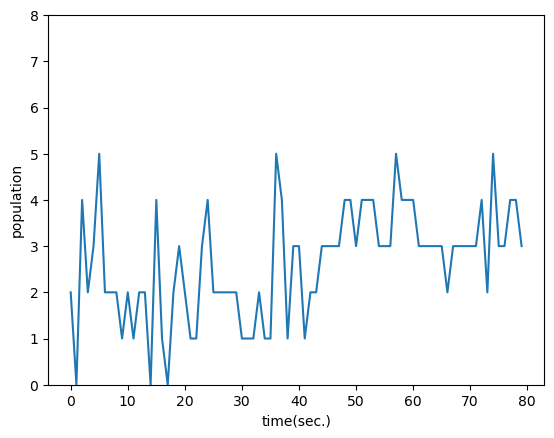

In [2]:
# matplotlib ライブラリをインポート
import matplotlib.pyplot as plt

# 時間と人数のグラフを作成
plt.plot(list_df["time"], list_df["people"])

# X軸のラベルを設定
plt.xlabel('time(sec.)')

# Y軸のラベルを設定
plt.ylabel('population')

# Y軸の範囲を0から8に設定
plt.ylim(0, 8)

# グラフを表示
plt.show()

### 移動平均を計算することでノイズの影響を除去する

In [3]:
import numpy as np
def moving_average(x, y):
    y_conv = np.convolve(y, np.ones(5)/float(5), mode='valid')
    x_dat = np.linspace(np.min(x), np.max(x), np.size(y_conv))
    return x_dat, y_conv

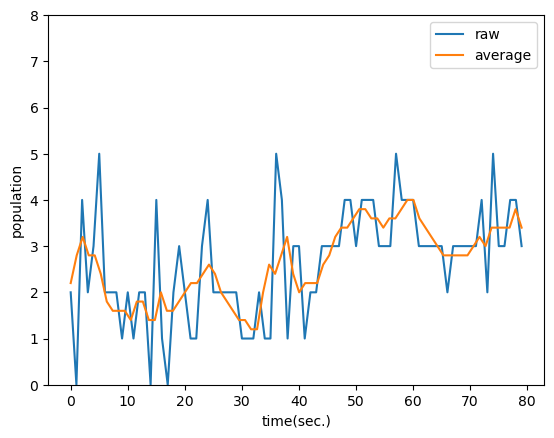

In [4]:
plt.plot(list_df["time"], list_df["people"], label="raw")
ma_x, ma_y = moving_average(list_df["time"], list_df["people"])
plt.plot(ma_x,ma_y, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,8)
plt.legend()
plt.show()